# Construction PPE Object Detection: 
### <b><u>Hybrid Model Bias Check</b></u>
##### AAI-501 Group 4: Fatimat Atanda, Victor Hugo Germano, Darin Verduzco
GitHub: https://github.com/victorhg/aai-501-final-project

# Hybrid Model dataset summary for bias check on unseen data:

<br> 12/23/24 update: hybrid bias check dataset (2,924 total images):
<br> Kaggle dataset - 178 images manually annotated (6.09% of total)
<br> Unseen data of custom 58 images and labels for a holdout test set manually annotated (1.98% of total) 
<br> 2688 images for auto annotation (91.93% of total)
<br><br>Class labels in the datasets:
<br>0: Hardhat
<br>1: Mask
<br>2: NO-Hardhat
<br>3: NO-Mask
<br>4: NO-Safety Vest
<br>5: Person
<br>6: Safety Cone
<br>7: Safety Vest
<br>8: Machinery
<br>9: Vehicle

### Import Modules and Libraries

In [1]:
import os # File 
import cv2 # Opencv for images
import yaml
import glob
import torch
import shutil
import random
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from pathlib import Path
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from ultralytics import YOLO # For obeject detection
import albumentations as A # For image augmentation
from albumentations.pytorch import ToTensorV2 # For image formating
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")

C:\Users\DARiN\AppData\Roaming\Python\Python312\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Make predictions on <u>**unseen dataset**</u> test set

In [2]:
input_name2 = 'hybrid final 010125pm'
model = YOLO("runs/detect/" + input_name2 +"/weights/best.pt")

manual_test_images_dir = 'datasets/manually_annotated/TEST/images'
manual_test_labels_dir = 'datasets/manually_annotated/TEST/labels'

# Remove previous predictions
detect_path = "runs/detect/"
for folder in os.listdir(detect_path):
    folder_path = os.path.join(detect_path, folder)
    if os.path.isdir(folder_path) and folder.startswith("predict"):
        shutil.rmtree(folder_path, ignore_errors=True)

# Make predictions on all custom images
results = model.predict(
    f"{manual_test_images_dir}/scene*.jpg",
    save=True,
    conf=0.6,
    agnostic_nms=True,
    iou=0.8,
    verbose=False,
    seed = 88
)

Results saved to runs\detect\predict


# Bias Checks:

### Initial Qualitative Assessment
Manually inspect a sample of the model's predictions to visually evaluate its performance and look for patterns of bias in detections.
<br>
Load a subset of images and check if the model struggles with certain objects, environments, or conditions.

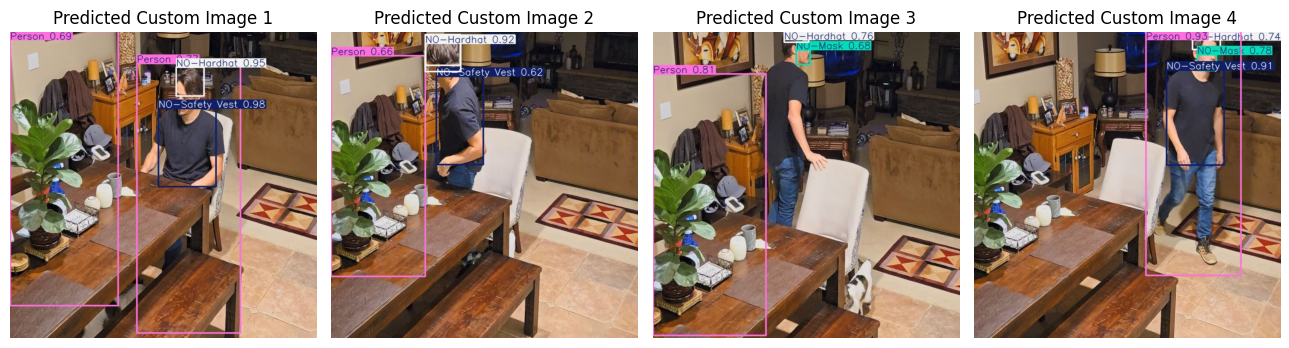

In [3]:
# Show predicted "scene" images
scene_predicted_paths = glob.glob("runs/detect/predict/scene*.jpg")[44:58] # Image range chosen for 4 images

if len(scene_predicted_paths) < 3:
    print("Not enough predictions found!")
else:
    fig, axes = plt.subplots(1, 4, figsize=(13, 6))  # 1 row, 3 columns
    for i, ax in enumerate(axes):
        image = mpimg.imread(scene_predicted_paths[i])
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f"Predicted Custom Image {i + 1}")
    plt.tight_layout()
    plt.show()

## Interpretation:
On first glance, it seems to work aside from some confusion on Person and Machinery.
<br>May want to increase confidence threshold for all predictions.

### Save the predicted bbox coordinate data:

In [4]:
# Collect predictions into a DataFrame
predictions = []
for result in results:
    for box in result.boxes.data:  # YOLO v8 structure
        x1, y1, x2, y2, conf, cls = box.tolist()  # Coordinates, confidence, and class
        predictions.append({'image': result.path, 'class': int(cls), 'bbox': [x1, y1, x2, y2], 'conf': conf})

predictions_df = pd.DataFrame(predictions)
predictions_df['image'] = predictions_df['image'].apply(lambda x: os.path.basename(x)) # strip path from filename

### Load predefined ground truth bbox data

In [5]:
# Load ground truth annotations
ground_truths = []
for label_file in os.listdir(manual_test_labels_dir):
    if label_file.endswith(".txt"):
        image_name = label_file.replace(".txt", ".jpg")
        with open(os.path.join(manual_test_labels_dir, label_file), 'r') as f:
            for line in f:
                cls, x_center, y_center, width, height = map(float, line.strip().split())
                ground_truths.append({
                    'image': image_name,
                    'class': int(cls),
                    'bbox': [x_center, y_center, width, height]  # YOLO format
                })

ground_truths_df = pd.DataFrame(ground_truths)

In [6]:
predictions_df.head()

,image,class,bbox,conf
0,scene1_all_1.jpg,0,"[469.28955078125, 26.16771125793457, 517.75634...",0.960934
1,scene1_all_1.jpg,5,"[407.32000732421875, 20.86480712890625, 571.69...",0.959624
2,scene1_all_1.jpg,7,"[426.65826416015625, 98.52215576171875, 541.91...",0.869987
3,scene1_all_1.jpg,8,"[0.0, 401.7276611328125, 120.61820220947266, 5...",0.752777
4,scene1_all_2.jpg,0,"[503.8622741699219, 21.861125946044922, 628.22...",0.916093


In [7]:
ground_truths_df.head()

,image,class,bbox
0,scene1_all_1.jpg,1,"[0.767531, 0.145336, 0.055563, 0.050984]"
1,scene1_all_1.jpg,7,"[0.757711, 0.275375, 0.151203, 0.25275]"
2,scene1_all_1.jpg,5,"[0.755242, 0.379492, 0.203703, 0.677891]"
3,scene1_all_1.jpg,0,"[0.771016, 0.075391, 0.078906, 0.066406]"
4,scene1_all_2.jpg,5,"[0.771844, 0.522648, 0.456313, 0.954703]"


### Convert coordinates from normalized to absolute format

In [8]:
#Convert normalized to absolute format
image_width = 640
image_height = 640
def yolo_to_absolute(bbox, image_width, image_height):
    x_center, y_center, width, height = bbox
    x1 = (x_center - width / 2) * image_width
    y1 = (y_center - height / 2) * image_height
    x2 = (x_center + width / 2) * image_width
    y2 = (y_center + height / 2) * image_height
    return [x1, y1, x2, y2]
# apply to ground truth values
ground_truths_df['bbox'] = ground_truths_df['bbox'].apply(
    lambda bbox: yolo_to_absolute(bbox, image_width, image_height)
)

In [9]:
ground_truths_df.head()

,image,class,bbox
0,scene1_all_1.jpg,1,"[473.43967999999995, 76.70016, 509.0, 109.3299..."
1,scene1_all_1.jpg,7,"[436.55008000000004, 95.36, 533.32, 257.119999..."
2,scene1_all_1.jpg,5,"[418.16992, 25.94975999999999, 548.53983999999..."
3,scene1_all_1.jpg,0,"[468.20032000000003, 27.00032, 518.70016, 69.5..."
4,scene1_all_2.jpg,5,"[347.96, 28.98976000000001, 640.0003200000001,..."


### Calculate IoU

In [10]:
from shapely.geometry import box

def calculate_iou(box1, box2):
    # Convert [x1, y1, x2, y2] into shapely boxes
    box1 = box(*box1)
    box2 = box(*box2)
    intersection = box1.intersection(box2).area
    union = box1.union(box2).area
    return intersection / union

# Match predictions to ground truth and calculate IoU
ious = []
for _, pred in predictions_df.iterrows():
    gt_matches = ground_truths_df[ground_truths_df['image'] == pred['image']]
    for _, gt in gt_matches.iterrows():
        if pred['class'] == gt['class']:  # Match classes
            pred_bbox = pred['bbox']  # [x1, y1, x2, y2]
            gt_bbox = gt['bbox']  # Convert YOLO bbox to absolute format
            iou = calculate_iou(pred_bbox, gt_bbox)
            ious.append({'object_class': pred['class'], 'iou': iou})

iou_df = pd.DataFrame(ious)

# Average IoU per class item predicted

In [11]:
# Group by object class and compute average IoU across all predictions for that class
# (1.0 iou equals perfect alignment with ground truth)
mean_iou = iou_df.groupby('object_class')['iou'].mean()
mean_iou_rounded = mean_iou.round(2)
print(mean_iou_rounded)

object_class
0    0.84
2    0.75
3    0.57
4    0.73
5    0.57
7    0.79
Name: iou, dtype: float64


# ****Class 1 (Mask) is missing

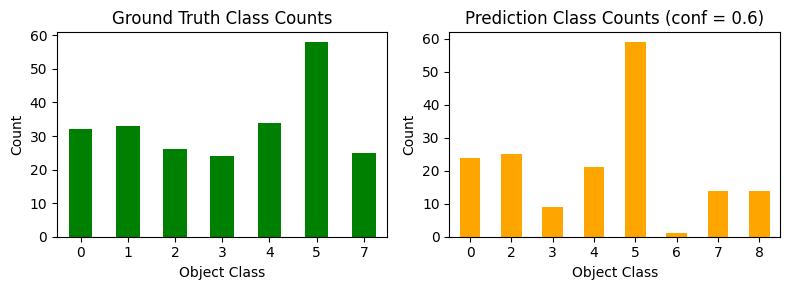

In [12]:
import matplotlib.pyplot as plt

# Count occurrences of each class in ground truth
class_counts = ground_truths_df['class'].value_counts()

# Sort class counts by object class in alphanumerical order
sorted_class_counts = class_counts.sort_index()

# Count occurrences of each class in predictions
pred_class_counts = predictions_df['class'].value_counts()
sort_pred_class_counts = pred_class_counts.sort_index()

# Create a figure with 1 row and 2 columns for subplots
plt.figure(figsize=(8, 3))

# Plot ground truth class counts in the first subplot
plt.subplot(1, 2, 1)  # (rows, columns, index)
sorted_class_counts.plot(kind='bar', color='green')
plt.title('Ground Truth Class Counts')
plt.xlabel('Object Class')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Plot prediction class counts in the second subplot
plt.subplot(1, 2, 2)  # (rows, columns, index)
sort_pred_class_counts.plot(kind='bar', color='orange')
plt.title('Prediction Class Counts (conf = 0.6)')
plt.xlabel('Object Class')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Show both plots
plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()

### ***No predictions for class 1 (Mask) found

A significant imbalance in the predicted class distribution may suggest bias, especially if you know the real-world distribution should be different.

### Confidence Score Analysis
Analyze the confidence scores, identify patterns of overconfidence or underconfidence.
<br>Consistently lower confidence scores for certain classes could indicate a bias in the model's predictions.

In [13]:
from collections import defaultdict

# Extract the relevant columns from the predictions dataframe
predictions = predictions_df[['class', 'conf']].to_dict(orient='records')

# Aggregate confidence by class
confidence_by_class = defaultdict(list)
for pred in predictions:
    confidence_by_class[pred['class']].append(pred['conf'])

# Calculate average confidence per class
avg_confidence = {cls: sum(scores) / len(scores) for cls, scores in confidence_by_class.items()}

# Round the average confidence values to 2 decimal places
avg_conf_round = {cls: round(conf, 2) for cls, conf in avg_confidence.items()}

# Print the average confidence for each class
print(f"Average Confidence Score for Each Class:\n {avg_conf_round}")

Average Confidence Score for Each Class:
 {0: 0.91, 5: 0.78, 7: 0.74, 8: 0.69, 4: 0.77, 3: 0.76, 2: 0.83, 6: 0.6}


# WIP fix comparison of y_true to y_pred so it only makes the comparison if the image name of pred matches gt_df

### False Positive and False Negatives
Identify which classes have the highest false positives (model predicts a class that is not present in the ground truth)
<br>and false negatives (model fails to predict the true class).

In [33]:
from collections import defaultdict

# Initialize counters for each class
true_positives = defaultdict(int)
false_positives = defaultdict(int)
false_negatives = defaultdict(int)

# Create dictionaries for easy lookup
ground_truth_dict = ground_truths_df.set_index('image')['class'].to_dict()
predictions_dict = predictions_df.set_index('image')['class'].to_dict()

# Iterate through ground truths
for image, true_class in ground_truth_dict.items():
    if image in predictions_dict:
        predicted_class = predictions_dict[image]
        if predicted_class == true_class:
            true_positives[true_class] += 1  # Correct prediction
        else:
            false_negatives[true_class] += 1  # Missed correct class
            false_positives[predicted_class] += 1  # Incorrect prediction
    else:
        false_negatives[true_class] += 1  # No prediction for this ground truth

# Iterate through predictions to find false positives
for image, predicted_class in predictions_dict.items():
    if image not in ground_truth_dict:
        false_positives[predicted_class] += 1  # Prediction with no ground truth

# Output results by class
print("order of y_pred matched y_true (True Positive):")
for class_label, count in true_positives.items():
    print(f"Class {class_label}: {count}")

print("\nPrediction made was not in ground truth (False Positive):")
for class_label, count in false_positives.items():
    print(f"Class {class_label}: {count}")

print("\nFailed to predict ground truth (False Negative):")
for class_label, count in false_negatives.items():
    print(f"Class {class_label}: {count}")

order of y_pred matched y_true (True Positive):
Class 4: 2
Class 5: 2
Class 7: 1

Prediction made was not in ground truth (False Positive):
Class 8: 7
Class 5: 18
Class 4: 9
Class 3: 3
Class 2: 4
Class 0: 3
Class 7: 6
Class 6: 1

Failed to predict ground truth (False Negative):
Class 0: 7
Class 1: 13
Class 7: 4
Class 5: 14
Class 4: 4
Class 3: 5
Class 2: 4


False Positives (FP) and False Negatives (FN) can often be linked to class imbalances or biases in your model, especially when some classes are underrepresented or overrepresented in the training data.

### Class-Wise Performance Analysis
Significant differences in metrics between classes may indicate bias toward or against certain object categories.

In [25]:
from sklearn.metrics import classification_report

# Create dictionaries for easy lookup
ground_truth_dict = ground_truths_df.set_index('image')['class'].to_dict()
predictions_dict = predictions_df.set_index('image')['class'].to_dict()

# Align the predictions with ground truths using the 'image' column as key
aligned_y_true = []
aligned_y_pred = []

# Iterate through ground truths and match with predictions
for image, true_class in ground_truth_dict.items():
    if image in predictions_dict:
        aligned_y_true.append(true_class)
        aligned_y_pred.append(predictions_dict[image])

# Generate the classification report
report = classification_report(aligned_y_true, aligned_y_pred, output_dict=True)

# Print the report with added line breaks for better readability
for label, metrics in report.items():
    if label != 'accuracy':  # Skip accuracy line for formatting
        print(f"Class: {label}\n")
        for metric, value in metrics.items():
            print(f"{metric}: {value}")
        print("\n" + "-"*40)  # Add a separator for each class

Class: 0

precision: 0.0
recall: 0.0
f1-score: 0.0
support: 7.0

----------------------------------------
Class: 1

precision: 0.0
recall: 0.0
f1-score: 0.0
support: 13.0

----------------------------------------
Class: 2

precision: 0.0
recall: 0.0
f1-score: 0.0
support: 4.0

----------------------------------------
Class: 3

precision: 0.0
recall: 0.0
f1-score: 0.0
support: 5.0

----------------------------------------
Class: 4

precision: 0.18181818181818182
recall: 0.3333333333333333
f1-score: 0.23529411764705882
support: 6.0

----------------------------------------
Class: 5

precision: 0.1
recall: 0.125
f1-score: 0.1111111111111111
support: 16.0

----------------------------------------
Class: 6

precision: 0.0
recall: 0.0
f1-score: 0.0
support: 0.0

----------------------------------------
Class: 7

precision: 0.14285714285714285
recall: 0.2
f1-score: 0.16666666666666666
support: 5.0

----------------------------------------
Class: 8

precision: 0.0
recall: 0.0
f1-score: 0.0
sup

Overpredictions may skew all results above since y_pred is less likely to match y_true,
<br>reduce overpredictions and re-run for best representation.